In [1]:
import holoocean
import numpy as np
import json
import math
import sys
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import operator

from IPython.display import display
from IPython.display import clear_output
import IPython

import pygame
from Mapping.EnvironmentMap import EnvironmentMap
from Mapping.BoundingBox import BoundingBox
from Mapping.Cell import Cell

pygame 2.1.2 (SDL 2.0.16, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
with open("./config.json", 'r') as f:
    cfg = json.load(f)

In [3]:
config_front = cfg['agents'][0]['sensors'][-2]["configuration"]
azi_front = config_front["Azimuth"]
ele_front = config_front["Elevation"]
minR_front = config_front["RangeMin"]
maxR_front = config_front['RangeMax']
binsR_front = config_front["RangeBins"]
binsA_front = config_front["AzimuthBins"]

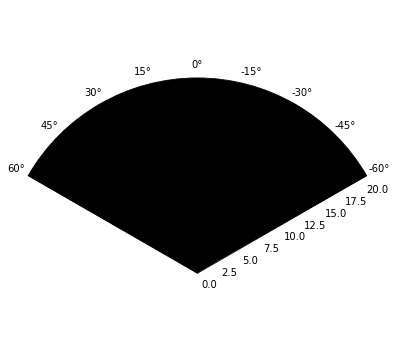

In [4]:
%matplotlib inline
plt.ion()
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,5))
ax.set_theta_zero_location("N")
ax.set_thetamin(-azi_front/2)
ax.set_thetamax(azi_front/2)

theta_front = np.linspace(-azi_front/2, azi_front/2, binsA_front)*np.pi/180
r_front = np.linspace(minR_front, maxR_front, binsR_front)
T_front, R_front = np.meshgrid(theta_front, r_front)
z_front = np.zeros_like(T_front)

plt.grid(False)
plot = ax.pcolormesh(T_front, R_front, z_front, cmap='gray', shading='auto', vmin=0, vmax=1)
plt.tight_layout()
fig.set_facecolor("w")
fig.canvas.flush_events()

In [5]:
config_depth = cfg['agents'][0]['sensors'][-1]["configuration"]
azi_depth = config_depth["Azimuth"]
ele_depth = config_depth["Elevation"]
minR_depth = config_depth["RangeMin"]
maxR_depth = config_depth['RangeMax']
binsR_depth = config_depth["RangeBins"]
binsA_depth = config_depth["AzimuthBins"]

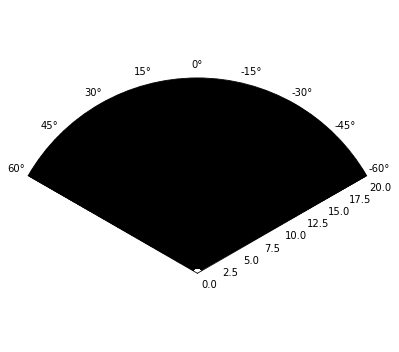

In [6]:
%matplotlib inline
plt.ion()
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,5))
ax.set_theta_zero_location("N")
ax.set_thetamin(-azi_depth/2)
ax.set_thetamax(azi_depth/2)

theta_depth = np.linspace(-azi_depth/2, azi_depth/2, binsA_depth)*np.pi/180
r_depth = np.linspace(minR_depth, maxR_depth, binsR_depth)
T_depth, R_depth = np.meshgrid(theta_depth, r_depth)
z_depth = np.zeros_like(T_depth)

plt.grid(False)
plot = ax.pcolormesh(T_depth, R_depth, z_depth, cmap='gray', shading='auto', vmin=0, vmax=1)
plt.tight_layout()
fig.set_facecolor("w")
fig.canvas.flush_events()

In [7]:
pygame.quit()
pygame.init()

pyg_res = (640,480)

screen = pygame.display.set_mode(pyg_res)
screen.fill((255,255, 255))
pygame.display.set_caption("Robot Map")

def pyg_draw(rob_pos, env_map : EnvironmentMap, occ, cov, screen, res, bound=(20,20)):
    screen.fill((255,255, 255))
    boundary = env_map.boundary
    (minx, miny), (maxx, maxy) = boundary.get_bounding_box() 
    
    rob_x = (rob_pos[0] - minx)/(maxx - minx) * (res[0] - bound[0])
    rob_y = (rob_pos[1] - miny)/(maxy - miny) * (res[1] - bound[1])

    for x,y in cov:
        normx = (x - minx)/(maxx - minx) * (res[0] - bound[0])
        normy = (y - miny)/(maxy - miny) * (res[1] - bound[1])
        
        pygame.draw.circle(screen, (0,255,0), (normx, normy), 1.)
    
    for x,y,_ in occ:
        normx = (x - minx)/(maxx - minx) * (res[0] - bound[0])
        normy = (y - miny)/(maxy - miny) * (res[1] - bound[1])
        
        pygame.draw.circle(screen, (255,0,0), (normx, normy), 7.)
    
    pygame.draw.rect(screen, (0,0,0), (rob_x,rob_y,20,20))

libGL error: No matching fbConfigs or visuals found
libGL error: failed to load driver: swrast


In [8]:
env = holoocean.make(scenario_cfg=cfg)

In [9]:
def get_coordinates(r, theta):
#    return r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi), - r * np.cos(theta)
    return r * np.cos(theta), r * np.sin(theta), 0

In [10]:
def get_coordinates_from_sonar_data_front(sonar_data, robot_coordinates, R=R_front, T=T_front):
    occupied = []
    arr_j = []
    for index_1, i in enumerate(sonar_data):
        for index_2, j in enumerate(i):
            if index_2 in arr_j: continue
            if j == 0.: continue
            coords = get_coordinates(R[index_1][index_2], T[index_1][index_2])
            arr_j += [index_2]
            occupied.append(tuple(map(operator.add, coords, robot_coordinates)))
    return occupied

In [11]:
def get_coordinates_depth(r, theta):
#    return r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi), - r * np.cos(theta)
    return 0, r * np.sin(theta), -r * np.cos(theta) 

In [12]:
def get_coordinates_from_sonar_data_depth(sonar_data, robot_coordinates, R=R_depth, T=T_depth):
    result = []
    for index_1, i in enumerate(sonar_data):
        if i.any():
            # array has at least one value other than zero
            for index_2, j in enumerate(i):
                if j == 0.: continue
                coords = get_coordinates_depth(R[index_1][index_2], T[index_1][index_2])
                result.append(tuple(map(operator.add, coords, robot_coordinates)))
    return result

In [13]:
action = np.zeros(8)
action[4:8] += 200

states = env.tick()
env_occ = []
env_cov = []
env_map : EnvironmentMap = EnvironmentMap((.5,.5), (.5,.5), (.5,.5))

In [14]:
front_ak = maxR_front / np.cos(np.deg2rad(azi_front/2.))
boundary_relativ_front : BoundingBox = BoundingBox((0, -front_ak), (20, front_ak)) # x,y. z is fixed

In [15]:
y_tmp = np.sin(theta_depth)*maxR_depth

In [16]:
y_rel_uncovered = [y_tmp[0], y_tmp[-1]]
y_rel_covered = y_tmp[1:-1]

In [17]:
del y_tmp

In [18]:
x_rel_covered = np.sin(np.deg2rad(ele_depth))*maxR_depth

In [19]:
depth_ak = y_rel_uncovered[-1]
boundary_relativ_depth : BoundingBox = BoundingBox((-x_rel_covered, -front_ak), (x_rel_covered, front_ak)) #x,y.

In [20]:
pyg_draw((states["PoseSensor"][0][3], states["PoseSensor"][1][3], states["PoseSensor"][2][3]), env_map, env_occ, env_cov, screen, pyg_res)
num_ticks = 5
for i in range(int(400/num_ticks)):
    env.act('auv0', action)
    states = env.tick(num_ticks=num_ticks)
    clear_output()
    pygame.display.flip()
    boundary_robot : BoundingBox = BoundingBox((states["PoseSensor"][0][3], states["PoseSensor"][1][3]),(states["PoseSensor"][0][3], states["PoseSensor"][1][3]))
    if 'depth' in states:
        s = states['depth']
        coords = get_coordinates_from_sonar_data_depth(s, (states["PoseSensor"][0][3], states["PoseSensor"][1][3], states["PoseSensor"][2][3]))
        env_map.update_depth_scan(coords)
        explored_points = [(states["PoseSensor"][0][3], y) for y in y_rel_covered]
        env_cov += explored_points
        env_map.update_covered_points(explored_points, boundary_relativ_depth + boundary_robot)
        
        unexplored_points = [(states["PoseSensor"][0][3], y) for y in y_rel_covered] + [(x_rel_covered, y) for y in y_rel_uncovered] + [(-x_rel_covered, y) for y in y_rel_uncovered]
        
        env_map.update_unexplored_points(unexplored_points, boundary_relativ_depth + boundary_robot)
    if 'front' in states:
        s = states['front']        
        occ = get_coordinates_from_sonar_data_front(s, (states["PoseSensor"][0][3], states["PoseSensor"][1][3], states["PoseSensor"][2][3]))
        if len(occ) != 0:
            env_occ += occ
            boundary_abs_front : BoundingBox = boundary_relativ_front + boundary_robot
            env_map.update_collision_points(occ, boundary_abs_front)
    pyg_draw((states["PoseSensor"][0][3], states["PoseSensor"][1][3], states["PoseSensor"][2][3]), env_map, env_occ, env_cov, screen, pyg_res)

In [21]:
len(env_map.unexplored_points)

5154

In [22]:
len(env_map.collision_points)

94

In [23]:
len(env_map.covered_points)

5152

In [24]:
len(env_map.scan)

2212